In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../ray-delay')
from stim_surface_code.patch import SurfaceCodePatch
from stim_surface_code.memory import MemoryPatch
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import GoogleNoiseParamsNoRandomRays
import numpy as np

import sinter
import matplotlib.pyplot as plt

In [2]:
def get_many_circ_code(d_range, p_range, init_basis, observable_basis, meas_mode):
    tasks = []
    for d in d_range:
        patch1 = ZXXZPatch(d, d, d, id_offset=0)
        patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
        zz_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])
        
        for p in p_range:
            noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
            noise_params.error_means = {'T1': 1, 'T2': 1, 'readout_err': p, 'gate1_err': p, 'gate2_err': p, 'erasure':0}
            cosmic_noise = NoiseModelPatch(zz_op.patch_collection, noise_params)
            # print(zz_op.patch_collection.error_vals['gate1_err'][0])
            circ = zz_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, meas_mode=meas_mode, expect_bell=True)
            
            tasks.append(sinter.Task(circuit=circ, json_metadata={'p': p, 'd': int(d), 'meas_mode': meas_mode, 'init_basis': init_basis, 'observable_basis': observable_basis}))
    return tasks

def get_all_xxtl_code(d_range, p_range):
    return get_many_circ_code(d_range, p_range, "Z", "Z", "01TL")

def get_all_zl_code(d_range, p_range):
    return get_many_circ_code(d_range, p_range, "X", "X", "")


In [3]:
def produce_results(d_range, p_range):
    xxtl_circs = get_all_xxtl_code(d_range, p_range)
    zl_circs = get_all_zl_code(d_range, p_range)
    circs = xxtl_circs + zl_circs
    
    print(f"Running {len(circs)} circuits")
    
    results = sinter.collect(
        num_workers=4,
        max_shots=10_000_000,
        max_errors=100,
        tasks=circs,
        decoders=['pymatching'],
        count_observable_error_combos=True,
    )
    return results

def post_process_results(results):
    # for each p, d, combo, we want to store the error rates
    
    raw_TL = {}
    raw_ZL = {}
    processed = {}
    
    for res in results:
        d = res.json_metadata['d']
        p = res.json_metadata['p']
        meas_mode = res.json_metadata['meas_mode']
        
        # init_basis = res.json_metadata['init_basis']
        # observable_basis = res.json_metadata['observable_basis']
        key = (d, p)
        
        if meas_mode == "01TL":
            raw_TL[key] = {"shots": res.shots, "errs": res.custom_counts}
        else:
            raw_ZL[key] = {"shots": res.shots, "errs": res.custom_counts}
    
    
    # enumerate through both dicts and calculate the error rates
    for dp_pair in raw_TL.keys():
        d, p = dp_pair
        
        out = {}
        
        tl_data = raw_TL[dp_pair]
        tl_shots = tl_data["shots"]
        
        zl_data = raw_ZL[dp_pair]
        zl_shots = zl_data["shots"]
        
        out["tl"] = {k: v / tl_shots for k, v in tl_data["errs"].items()}
        out["zl"] = {k: v / zl_shots for k, v in zl_data["errs"].items()}
        
        tl_err_rate = 0
        
        # tl err rates
        for err_type, err_rate in tl_data["errs"].items():
            err_name = err_type.split("=")[1]
            
            # will be X0, X1, TL
            # first error is 100% bad, second error doesn't matter, third error matters half
            if err_name.startswith("E"):
                tl_err_rate += err_rate
            elif err_name.endswith("E"):
                tl_err_rate += err_rate / 2
        tl_err_rate = tl_err_rate / tl_shots
        
        out["tl_err_rate"] = tl_err_rate
        
        # zl err rates
        assert len(out["zl"]) <= 1, out["zl"]
        zl_err_rate = out["zl"].get("obs_mistake_mask=E", 0)
        out["zl_err_rate"] = zl_err_rate
        
        out["error_rate"] = 1 - (1 - tl_err_rate) * (1 - zl_err_rate)
        processed[dp_pair] = out
    
    return processed, raw_TL, raw_ZL


In [4]:
d_range = [5, 7, 9]
p_range = np.geomspace(1e-5, 1e-3, 7)


results1 = produce_results(d_range, p_range)

Running 42 circuits


In [5]:
processed, raw_TL, raw_ZL = post_process_results(results1)

In [6]:
processed

{(5,
  2.1544346900318823e-05): {'tl': {'obs_mistake_mask=E_E': 2e-07,
   'obs_mistake_mask=E__': 2e-07}, 'zl': {'obs_mistake_mask=E': 1.1e-06}, 'tl_err_rate': 4e-07, 'zl_err_rate': 1.1e-06, 'error_rate': 1.4999995600062377e-06},
 (5,
  1e-05): {'tl': {'obs_mistake_mask=E_E': 1e-07,
   'obs_mistake_mask=_EE': 1e-07}, 'zl': {'obs_mistake_mask=E': 5e-07}, 'tl_err_rate': 1.5e-07, 'zl_err_rate': 5e-07, 'error_rate': 6.49999924884348e-07},
 (5,
  0.0001): {'tl': {'obs_mistake_mask=_E_': 1.3816600076072575e-05,
   'obs_mistake_mask=E__': 8.398325536436271e-06,
   'obs_mistake_mask=E_E': 4.605533358690858e-06,
   'obs_mistake_mask=_EE': 8.127411809454455e-07}, 'zl': {'obs_mistake_mask=E': 2.8353932690464166e-05}, 'tl_err_rate': 1.3410229485599852e-05, 'zl_err_rate': 2.8353932690464166e-05, 'error_rate': 4.176378194342689e-05},
 (5,
  4.641588833612782e-05): {'tl': {'obs_mistake_mask=E__': 2.3e-06,
   'obs_mistake_mask=_E_': 1.4e-06,
   'obs_mistake_mask=E_E': 9e-07}, 'zl': {'obs_mistake_mask=

Text(0.5, 1.0, 'Error rate vs p for different d values')

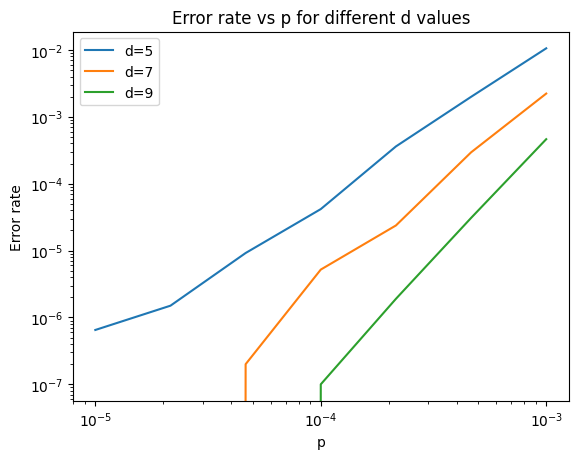

In [7]:


# plot results
for d_val in d_range:
    # get all relevant err rates
    err_rates = [processed[(d_val, p)]["error_rate"] for p in p_range]
    # err_rates = [processed[(d_val, p)]["tl"].get("obs_mistake_mask=_EE", 0) for p in p_range]
    
    plt.plot(p_range, err_rates, label=f"d={d_val}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Error rate")
plt.legend()
plt.title("Error rate vs p for different d values")